* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Use a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 6](#step6): Write your Algorithm
* [Step 7](#step7): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

### Import Dog Dataset

In the code cell below, we import a dataset of dog images.  We populate a few variables through the use of the `load_files` function from the scikit-learn library:
- `train_files`, `valid_files`, `test_files` - numpy arrays containing file paths to images
- `train_targets`, `valid_targets`, `test_targets` - numpy arrays containing onehot-encoded classification labels 
- `dog_names` - list of string-valued dog breed names for translating labels

In [4]:
##Python3.6
##Anaconda Env..
##Calvin Green

from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('dogImages/train')
valid_files, valid_targets = load_dataset('dogImages/valid')
test_files, test_targets = load_dataset('dogImages/test')

# load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("dogImages/train/*/"))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


### Import Human Dataset

In the code cell below, we import a dataset of human images, where the file paths are stored in the numpy array `human_files`.

In [5]:
import random
random.seed(8675309)

# load filenames in shuffled human dataset
human_files = np.array(glob("lfw/*/*"))
random.shuffle(human_files)

# print statistics about the dataset
print('There are %d total human images.' % len(human_files))

There are 13233 total human images.


Number of faces detected: 1


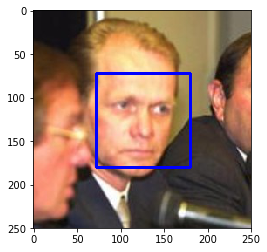

In [6]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[12])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

In [7]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0
#Convert to a vector

In [8]:
human_files_short = human_files[:100]
dog_files_short = train_files[:100]
# Do NOT modify the code above this line.

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.
#lfw_files_short = 
# Vectorize the face dectector function
faces_vecs = np.vectorize(face_detector)

human_faces = faces_vecs(human_files_short)
dog_faces = faces_vecs(dog_files_short)

# Calculate and print percentage of faces in each set
print('Faces detected in {:.0f}% of you humans sample dataset.'.format((sum(human_faces)/len(human_faces))*100))
print('Faces detected in {:.0f}% of the sample of the awesome dogs dataset.'.format((sum(dog_faces)/len(dog_faces))*100))

Faces detected in 99% of you humans sample dataset.
Faces detected in 11% of the sample of the awesome dogs dataset.


ANSWER:


99% of human faces  detected in sample dataset.

11% of dog faces detected in the sample dataset.


__Answer:__

We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on each of the datasets.

Answer:

Based on the description of the algorithm saying that it needs a clear view of the face for it to work accurately it will not be the best classifier. It is a simple way for  'augmented' types of data.. but definitely has room for improvement using other haar cascade features.


In [10]:
from keras.applications.resnet50 import ResNet50

# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

In [11]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

### Making Predictions with ResNet-50

Getting the 4D tensor ready for ResNet-50, and for any other pre-trained model in Keras, requires some additional processing.  First, the RGB image is converted to BGR by reordering the channels.  All pre-trained models have the additional normalization step that the mean pixel (expressed in RGB as $[103.939, 116.779, 123.68]$ and calculated from all pixels in all images in ImageNet) must be subtracted from every pixel in each image.  This is implemented in the imported function `preprocess_input`.  If you're curious, you can check the code for `preprocess_input` [here](https://github.com/fchollet/keras/blob/master/keras/applications/imagenet_utils.py).

Now that we have a way to format our image for supplying to ResNet-50, we are now ready to use the model to extract the predictions.  This is accomplished with the `predict` method, which returns an array whose $i$-th entry is the model's predicted probability that the image belongs to the $i$-th ImageNet category.  This is implemented in the `ResNet50_predict_labels` function below.

By taking the argmax of the predicted probability vector, we obtain an integer corresponding to the model's predicted object class, which we can identify with an object category through the use of this [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). 

In [12]:
from keras.applications.resnet50 import preprocess_input, decode_predictions

def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

In [13]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

In [14]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.

human_files_short = human_files[:100]
dog_files_short = train_files[:100]
# Do NOT modify the code above this line.

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.

# Vectorize the face dectector function
faces_vecs = np.vectorize(dog_detector)

human_faces = faces_vecs(human_files_short)
dog_faces = faces_vecs(dog_files_short)

# Calculate and print percentage of faces in each set
print('{:.0f}% of HUMANS detected in the sample dataset.'.format((sum(human_faces)/len(human_faces))*100))
print('{:.0f}% of DOGS the sample of the awesome dogs dataset.'.format((sum(dog_faces)/len(dog_faces))*100))

1% of HUMANS detected in the sample dataset.
100% of DOGS the sample of the awesome dogs dataset.


ANSWER:
    
1% of HUMANS detected in the sample dataset.

100% of DOGS detected in the sample dataset.

In [15]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|████████████████████████████████████████████████████████████████████████████████| 836/836 [01:16<00:00, 10.99it/s]


### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        model.summary()

We have imported some Python modules to get you started, but feel free to import as many modules as you need.  If you end up getting stuck, here's a hint that specifies a model that trains relatively fast on CPU and attains >1% test accuracy in 5 epochs:

![Sample CNN](images/sample_cnn.png)
           
__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  If you chose to use the hinted architecture above, describe why you think that CNN architecture should work well for the image classification task.

__Answer:__ 

Softmax activation to help reduce outliers data without removing them from the dataset

Convolutional layers apply a convolution to the input

Maxpooling And Global Average layers serves to reduce the dimensionality of the data and parameters in the network which tends to less overfitting. 

Dense Layers to fully connect the layers

with a dropout of .2 for 20% of neurons to be dropped each iteration.

one final dense layer of 133 for the number of categories with a softmax activation as well

In [16]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

model = Sequential()
model.add(Conv2D(16, (3,3), input_shape=(224,224,3), activation = 'softmax'))
model.add(MaxPooling2D(pool_size=(4,4)))
model.add(Conv2D(32, (6,6), activation= 'relu'))
model.add(Conv2D(236, (5,5), activation= 'relu'))
model.add(MaxPooling2D(pool_size =(4,4)))
model.add(Conv2D(48, (4,4), activation= 'softmax'))
model.add(Conv2D(48, (6,6), activation= 'relu'))
model.add(GlobalAveragePooling2D())
model.add(Dense(units=64, activation= 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units= 133, activation = 'softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 222, 222, 16)      448       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 55, 55, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 50, 50, 32)        18464     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 46, 46, 236)       189036    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 11, 11, 236)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 48)          181296    
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 3, 3, 48)          82992     
__________

### Compile the Model

In [17]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [21]:
from keras.callbacks import ModelCheckpoint  

### TODO: specify the number of epochs that you would like to use to train the model.

epochs = 10
### Do NOT modify the code below this line.

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/10
6680/6680 [==============================] - 3480s 521ms/step - loss: 4.8866 - acc: 0.0085 - val_loss: 4.8764 - val_acc: 0.0096
Epoch 2/10


4080/6680 [=================>............] - ETA: 54:58 - loss: 4.8605 - acc: 0.05 - ETA: 52:29 - loss: 4.8757 - acc: 0.02 - ETA: 50:15 - loss: 4.8745 - acc: 0.01 - ETA: 49:25 - loss: 4.8784 - acc: 0.01 - ETA: 47:55 - loss: 4.8711 - acc: 0.01 - ETA: 48:03 - loss: 4.8560 - acc: 0.00 - ETA: 48:20 - loss: 4.8630 - acc: 0.00 - ETA: 47:58 - loss: 4.8668 - acc: 0.00 - ETA: 48:22 - loss: 4.8702 - acc: 0.01 - ETA: 48:27 - loss: 4.8692 - acc: 0.01 - ETA: 47:54 - loss: 4.8751 - acc: 0.01 - ETA: 47:40 - loss: 4.8742 - acc: 0.01 - ETA: 47:28 - loss: 4.8773 - acc: 0.01 - ETA: 47:08 - loss: 4.8763 - acc: 0.01 - ETA: 47:25 - loss: 4.8731 - acc: 0.01 - ETA: 47:19 - loss: 4.8768 - acc: 0.01 - ETA: 47:01 - loss: 4.8774 - acc: 0.01 - ETA: 47:16 - loss: 4.8766 - acc: 0.01 - ETA: 47:03 - loss: 4.8754 - acc: 0.01 - ETA: 46:50 - loss: 4.8739 - acc: 0.01 - ETA: 47:21 - loss: 4.8740 - acc: 0.00 - ETA: 47:13 - loss: 4.8745 - acc: 0.00 - ETA: 46:57 - loss: 4.8753 - acc: 0.00 - ETA: 46:59 - loss: 4.8736 - acc: 0.

6680/6680 [==============================] - 3321s 497ms/step - loss: 4.8758 - acc: 0.0090 - val_loss: 4.8703 - val_acc: 0.0108
Epoch 3/10
6680/6680 [==============================] - 3149s 471ms/step - loss: 4.8701 - acc: 0.0100 - val_loss: 4.8701 - val_acc: 0.0108
Epoch 4/10


4080/6680 [=================>............] - ETA: 49:26 - loss: 4.9608 - acc: 0.0000e+ - ETA: 47:52 - loss: 4.9173 - acc: 0.0000e+ - ETA: 50:49 - loss: 4.8953 - acc: 0.0000e+ - ETA: 49:37 - loss: 4.8936 - acc: 0.0000e+ - ETA: 48:22 - loss: 4.8924 - acc: 0.0000e+ - ETA: 47:10 - loss: 4.8915 - acc: 0.0000e+ - ETA: 46:40 - loss: 4.8854 - acc: 0.0071   - ETA: 45:47 - loss: 4.8760 - acc: 0.00 - ETA: 45:06 - loss: 4.8761 - acc: 0.00 - ETA: 44:38 - loss: 4.8801 - acc: 0.00 - ETA: 43:55 - loss: 4.8721 - acc: 0.00 - ETA: 43:07 - loss: 4.8748 - acc: 0.00 - ETA: 42:34 - loss: 4.8775 - acc: 0.00 - ETA: 41:49 - loss: 4.8774 - acc: 0.00 - ETA: 41:10 - loss: 4.8758 - acc: 0.01 - ETA: 41:01 - loss: 4.8755 - acc: 0.01 - ETA: 40:38 - loss: 4.8741 - acc: 0.01 - ETA: 40:47 - loss: 4.8725 - acc: 0.01 - ETA: 40:15 - loss: 4.8742 - acc: 0.02 - ETA: 39:50 - loss: 4.8719 - acc: 0.02 - ETA: 39:24 - loss: 4.8680 - acc: 0.02 - ETA: 38:59 - loss: 4.8681 - acc: 0.02 - ETA: 38:36 - loss: 4.8685 - acc: 0.01 - ETA: 38

6680/6680 [==============================] - 2395s 359ms/step - loss: 4.8697 - acc: 0.0105 - val_loss: 4.8690 - val_acc: 0.0108
Epoch 5/10
6680/6680 [==============================] - 2352s 352ms/step - loss: 4.8677 - acc: 0.0094 - val_loss: 4.8686 - val_acc: 0.0108
Epoch 6/10


4080/6680 [=================>............] - ETA: 34:21 - loss: 4.8211 - acc: 0.0000e+ - ETA: 33:26 - loss: 4.8344 - acc: 0.0000e+ - ETA: 34:05 - loss: 4.8406 - acc: 0.0000e+ - ETA: 33:46 - loss: 4.8588 - acc: 0.0000e+ - ETA: 34:39 - loss: 4.8592 - acc: 0.0000e+ - ETA: 34:34 - loss: 4.8524 - acc: 0.0000e+ - ETA: 34:28 - loss: 4.8529 - acc: 0.0071   - ETA: 34:51 - loss: 4.8647 - acc: 0.00 - ETA: 34:33 - loss: 4.8617 - acc: 0.00 - ETA: 34:22 - loss: 4.8635 - acc: 0.00 - ETA: 34:10 - loss: 4.8750 - acc: 0.00 - ETA: 34:00 - loss: 4.8759 - acc: 0.00 - ETA: 33:59 - loss: 4.8743 - acc: 0.00 - ETA: 33:45 - loss: 4.8695 - acc: 0.00 - ETA: 33:38 - loss: 4.8716 - acc: 0.00 - ETA: 33:33 - loss: 4.8770 - acc: 0.00 - ETA: 33:37 - loss: 4.8794 - acc: 0.00 - ETA: 33:29 - loss: 4.8783 - acc: 0.00 - ETA: 33:35 - loss: 4.8758 - acc: 0.00 - ETA: 33:32 - loss: 4.8745 - acc: 0.00 - ETA: 33:26 - loss: 4.8712 - acc: 0.00 - ETA: 33:15 - loss: 4.8686 - acc: 0.00 - ETA: 33:06 - loss: 4.8665 - acc: 0.00 - ETA: 33

6680/6680 [==============================] - 2333s 349ms/step - loss: 4.8671 - acc: 0.0115 - val_loss: 4.8690 - val_acc: 0.0108
Epoch 7/10
6680/6680 [==============================] - 2334s 349ms/step - loss: 4.8665 - acc: 0.0106 - val_loss: 4.8702 - val_acc: 0.0108
Epoch 8/10


4080/6680 [=================>............] - ETA: 39:38 - loss: 4.8775 - acc: 0.0000e+ - ETA: 36:46 - loss: 4.8284 - acc: 0.0500   - ETA: 35:42 - loss: 4.8290 - acc: 0.03 - ETA: 35:52 - loss: 4.8338 - acc: 0.02 - ETA: 35:49 - loss: 4.8600 - acc: 0.02 - ETA: 35:28 - loss: 4.8547 - acc: 0.02 - ETA: 35:09 - loss: 4.8548 - acc: 0.02 - ETA: 35:13 - loss: 4.8516 - acc: 0.01 - ETA: 34:51 - loss: 4.8567 - acc: 0.01 - ETA: 34:52 - loss: 4.8618 - acc: 0.02 - ETA: 34:41 - loss: 4.8585 - acc: 0.01 - ETA: 34:26 - loss: 4.8609 - acc: 0.01 - ETA: 34:19 - loss: 4.8639 - acc: 0.01 - ETA: 34:14 - loss: 4.8665 - acc: 0.01 - ETA: 34:05 - loss: 4.8691 - acc: 0.01 - ETA: 33:54 - loss: 4.8653 - acc: 0.01 - ETA: 33:46 - loss: 4.8671 - acc: 0.01 - ETA: 33:48 - loss: 4.8657 - acc: 0.01 - ETA: 33:48 - loss: 4.8667 - acc: 0.01 - ETA: 33:39 - loss: 4.8639 - acc: 0.01 - ETA: 33:30 - loss: 4.8650 - acc: 0.01 - ETA: 33:22 - loss: 4.8644 - acc: 0.01 - ETA: 33:18 - loss: 4.8655 - acc: 0.01 - ETA: 33:08 - loss: 4.8673 -

6680/6680 [==============================] - 2388s 357ms/step - loss: 4.8664 - acc: 0.0105 - val_loss: 4.8689 - val_acc: 0.0108
Epoch 9/10
6680/6680 [==============================] - 2363s 354ms/step - loss: 4.8658 - acc: 0.0102 - val_loss: 4.8690 - val_acc: 0.0108
Epoch 10/10


4080/6680 [=================>............] - ETA: 41:30 - loss: 4.8393 - acc: 0.0000e+ - ETA: 40:34 - loss: 4.8651 - acc: 0.0000e+ - ETA: 38:26 - loss: 4.8495 - acc: 0.0167   - ETA: 37:35 - loss: 4.8558 - acc: 0.01 - ETA: 36:50 - loss: 4.8449 - acc: 0.02 - ETA: 37:14 - loss: 4.8460 - acc: 0.01 - ETA: 36:42 - loss: 4.8511 - acc: 0.01 - ETA: 36:17 - loss: 4.8498 - acc: 0.01 - ETA: 35:49 - loss: 4.8481 - acc: 0.02 - ETA: 35:31 - loss: 4.8546 - acc: 0.02 - ETA: 35:11 - loss: 4.8556 - acc: 0.01 - ETA: 35:02 - loss: 4.8566 - acc: 0.01 - ETA: 34:53 - loss: 4.8517 - acc: 0.01 - ETA: 34:40 - loss: 4.8611 - acc: 0.01 - ETA: 34:29 - loss: 4.8584 - acc: 0.01 - ETA: 34:18 - loss: 4.8599 - acc: 0.01 - ETA: 34:06 - loss: 4.8621 - acc: 0.01 - ETA: 33:59 - loss: 4.8672 - acc: 0.01 - ETA: 33:52 - loss: 4.8666 - acc: 0.01 - ETA: 33:47 - loss: 4.8666 - acc: 0.01 - ETA: 33:44 - loss: 4.8662 - acc: 0.01 - ETA: 33:40 - loss: 4.8682 - acc: 0.01 - ETA: 33:37 - loss: 4.8674 - acc: 0.01 - ETA: 33:35 - loss: 4.86

6680/6680 [==============================] - 2357s 353ms/step - loss: 4.8658 - acc: 0.0114 - val_loss: 4.8687 - val_acc: 0.0108


### Load the Model with the Best Validation Loss

In [22]:
model.load_weights('saved_models/weights.best.from_scratch.hdf5')

In [23]:
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 1.1962%


In [24]:
bottleneck_features = np.load('bottleneck_features/DogVGG16Data.npz')
train_VGG16 = bottleneck_features['train']
valid_VGG16 = bottleneck_features['valid']
test_VGG16 = bottleneck_features['test']

In [28]:
VGG16_model = Sequential()
VGG16_model.add(GlobalAveragePooling2D(input_shape=train_VGG16.shape[1:]))
VGG16_model.add(Dense(133, activation='softmax'))


VGG16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_5 ( (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 133)               68229     
Total params: 68,229
Trainable params: 68,229
Non-trainable params: 0
_________________________________________________________________


### Compile the Model

In [29]:
VGG16_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Train the Model

In [30]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG16.hdf5', 
                               verbose=1, save_best_only=True)

VGG16_model.fit(train_VGG16, train_targets, 
          validation_data=(valid_VGG16, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 11s 2ms/step - loss: 12.2508 - acc: 0.1316 - val_loss: 10.7077 - val_acc: 0.2228
Epoch 2/20
6680/6680 [==============================] - 4s 616us/step - loss: 10.1952 - acc: 0.2862 - val_loss: 10.1715 - val_acc: 0.2958
Epoch 3/20
6680/6680 [==============================] - 5s 685us/step - loss: 9.8292 - acc: 0.3388 - val_loss: 9.8872 - val_acc: 0.3222
Epoch 4/20
6680/6680 [==============================] - 4s 637us/step - loss: 9.5758 - acc: 0.3680 - val_loss: 9.8148 - val_acc: 0.3377
Epoch 5/20


6680/6680 [==============================] - 4s 625us/step - loss: 9.4879 - acc: 0.3853 - val_loss: 9.8338 - val_acc: 0.3305
Epoch 6/20
6680/6680 [==============================] - 4s 636us/step - loss: 9.4375 - acc: 0.3972 - val_loss: 9.7750 - val_acc: 0.3509
Epoch 7/20
6680/6680 [==============================] - 4s 626us/step - loss: 9.3713 - acc: 0.4022 - val_loss: 9.6756 - val_acc: 0.3437
Epoch 8/20
6680/6680 [==============================] - 4s 629us/step - loss: 9.2908 - acc: 0.4127 - val_loss: 9.7034 - val_acc: 0.3521
Epoch 9/20


6680/6680 [==============================] - 4s 623us/step - loss: 9.2205 - acc: 0.4151 - val_loss: 9.5224 - val_acc: 0.3617
Epoch 10/20
6680/6680 [==============================] - 4s 633us/step - loss: 9.1283 - acc: 0.4232 - val_loss: 9.4515 - val_acc: 0.3605
Epoch 11/20
6680/6680 [==============================] - 4s 605us/step - loss: 9.0845 - acc: 0.4299 - val_loss: 9.5030 - val_acc: 0.3605
Epoch 12/20
6680/6680 [==============================] - 4s 653us/step - loss: 9.0539 - acc: 0.4319 - val_loss: 9.4205 - val_acc: 0.3665
Epoch 13/20


6680/6680 [==============================] - 4s 648us/step - loss: 9.0205 - acc: 0.4335 - val_loss: 9.3749 - val_acc: 0.3689
Epoch 14/20
6680/6680 [==============================] - 4s 651us/step - loss: 8.9961 - acc: 0.4362 - val_loss: 9.3668 - val_acc: 0.3749
Epoch 15/20
6680/6680 [==============================] - 4s 641us/step - loss: 8.9808 - acc: 0.4379 - val_loss: 9.3282 - val_acc: 0.3749
Epoch 16/20
6680/6680 [==============================] - 4s 641us/step - loss: 8.8733 - acc: 0.4427 - val_loss: 9.2836 - val_acc: 0.3760
Epoch 17/20


6680/6680 [==============================] - 4s 634us/step - loss: 8.8419 - acc: 0.4467 - val_loss: 9.2118 - val_acc: 0.3904
Epoch 18/20
6680/6680 [==============================] - 4s 634us/step - loss: 8.8309 - acc: 0.4491 - val_loss: 9.2126 - val_acc: 0.3880
Epoch 19/20
6680/6680 [==============================] - 4s 625us/step - loss: 8.8171 - acc: 0.4491 - val_loss: 9.2252 - val_acc: 0.3868
Epoch 20/20
6680/6680 [==============================] - 4s 647us/step - loss: 8.7572 - acc: 0.4499 - val_loss: 9.1027 - val_acc: 0.3904


In [41]:
VGG16_model.load_weights('saved_models/weights.best.VGG16.hdf5')

In [42]:
# get index of predicted dog breed for each image in test set
VGG16_predictions = [np.argmax(VGG16_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG16]

# report test accuracy
test_accuracy = 100*np.sum(np.array(VGG16_predictions)==np.argmax(test_targets, axis=1))/len(VGG16_predictions)
print('Test accuracy: {:.4f}' % test_accuracy)

Test accuracy: 38.9952%


### Predict Dog Breed with the Model

In [31]:
from extract_bottleneck_features import *

def VGG16_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_VGG16(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = VGG16_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

In [32]:
### TODO: Obtain bottleneck features from another pre-trained CNN.
bottleneck_features = np.load('bottleneck_features/DogInceptionV3Data.npz')
train_inception = bottleneck_features['train']
valid_inception = bottleneck_features['valid']
test_inception = bottleneck_features['test']

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        <your model's name>.summary()
   
__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ 



1. Find Bottleneck
2. Contemplate network architecture
3. Used G.A.P. layers to reduce the spatial dimensions of a tensor.
4. Adding the Dense layers expand the network while allowing more information to be sent throughout the network.
5. Output layer must have 133 nodes because 133 categories and of softmax for activation.
6. 80% accuracy on test

In [31]:
### TODO: Define your architecture.
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

train_inception.shape

incept_model = Sequential()
incept_model.add(GlobalAveragePooling2D(input_shape=train_inception.shape[1:]))
incept_model.add(Dense(256,  activation='relu'))
incept_model.add(Dense(133, activation='softmax'))
incept_model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_3 ( (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               524544    
_________________________________________________________________
dense_4 (Dense)              (None, 133)               34181     
Total params: 558,725
Trainable params: 558,725
Non-trainable params: 0
_________________________________________________________________


### (IMPLEMENTATION) Compile the Model

In [34]:
### TODO: Compile the model.
incept_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.  

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [35]:
### TODO: Train the model.
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint  


checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.Inception.hdf5', 
                               verbose=1, save_best_only=True)

incept_model.fit(train_inception, train_targets, 
          validation_data=(valid_inception, valid_targets),
          epochs=20, batch_size=64, callbacks=[checkpointer], verbose=1)

# datagen_train = ImageDataGenerator(
#     width_shift_range=0.5,  
#     height_shift_range=0.5, 
#     horizontal_flip=True,
#     zoom_range=0.4) 

# # create and configure augmented image generator
# datagen_valid = ImageDataGenerator(
#     width_shift_range=0.1,  
#     height_shift_range=0.1, 
#     horizontal_flip=True,
#     zoom_range=0.2) 

# # fit augmented image generator on data
# datagen_train.fit(train_inception)
# datagen_valid.fit(valid_inception)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 13s 2ms/step - loss: 1.5146 - acc: 0.6490 - val_loss: 0.6518 - val_acc: 0.8168
Epoch 2/20
6680/6680 [==============================] - 9s 1ms/step - loss: 0.4886 - acc: 0.8493 - val_loss: 0.6228 - val_acc: 0.8251
Epoch 3/20


6680/6680 [==============================] - 9s 1ms/step - loss: 0.3607 - acc: 0.8805 - val_loss: 0.5939 - val_acc: 0.8287
Epoch 4/20
6680/6680 [==============================] - 9s 1ms/step - loss: 0.2581 - acc: 0.9183 - val_loss: 0.6179 - val_acc: 0.8275
Epoch 5/20


6680/6680 [==============================] - 10s 1ms/step - loss: 0.1856 - acc: 0.9391 - val_loss: 0.6026 - val_acc: 0.8359
Epoch 6/20
6680/6680 [==============================] - 9s 1ms/step - loss: 0.1506 - acc: 0.9549 - val_loss: 0.6080 - val_acc: 0.8287
Epoch 7/20


6680/6680 [==============================] - 9s 1ms/step - loss: 0.1079 - acc: 0.9675 - val_loss: 0.6369 - val_acc: 0.8371
Epoch 8/20
6680/6680 [==============================] - 9s 1ms/step - loss: 0.0924 - acc: 0.9732 - val_loss: 0.6320 - val_acc: 0.8491
Epoch 9/20


6680/6680 [==============================] - 9s 1ms/step - loss: 0.0857 - acc: 0.9738 - val_loss: 0.6255 - val_acc: 0.8563
Epoch 10/20
6680/6680 [==============================] - 9s 1ms/step - loss: 0.0583 - acc: 0.9837 - val_loss: 0.6517 - val_acc: 0.8467
Epoch 11/20


6680/6680 [==============================] - 9s 1ms/step - loss: 0.0411 - acc: 0.9889 - val_loss: 0.6571 - val_acc: 0.8455
Epoch 12/20
6680/6680 [==============================] - 9s 1ms/step - loss: 0.0457 - acc: 0.9874 - val_loss: 0.6901 - val_acc: 0.8563
Epoch 13/20


6680/6680 [==============================] - 9s 1ms/step - loss: 0.0428 - acc: 0.9891 - val_loss: 0.6526 - val_acc: 0.8419
Epoch 14/20
6680/6680 [==============================] - 11s 2ms/step - loss: 0.0220 - acc: 0.9961 - val_loss: 0.6507 - val_acc: 0.8491
Epoch 15/20


6680/6680 [==============================] - 11s 2ms/step - loss: 0.0232 - acc: 0.9948 - val_loss: 0.6735 - val_acc: 0.8455
Epoch 16/20
6680/6680 [==============================] - 9s 1ms/step - loss: 0.0233 - acc: 0.9939 - val_loss: 0.6836 - val_acc: 0.8455
Epoch 17/20


6680/6680 [==============================] - 9s 1ms/step - loss: 0.0271 - acc: 0.9925 - val_loss: 0.6596 - val_acc: 0.8551
Epoch 18/20
6680/6680 [==============================] - 9s 1ms/step - loss: 0.0248 - acc: 0.9955 - val_loss: 0.6598 - val_acc: 0.8479
Epoch 19/20


6680/6680 [==============================] - 8s 1ms/step - loss: 0.0207 - acc: 0.9955 - val_loss: 0.7288 - val_acc: 0.8479
Epoch 20/20
6680/6680 [==============================] - 8s 1ms/step - loss: 0.0450 - acc: 0.9900 - val_loss: 0.7554 - val_acc: 0.8383


In [36]:
### TODO: Load the model weights with the best validation loss.
incept_model.load_weights('saved_models/weights.best.Inception.hdf5')

In [37]:
### TODO: Calculate classification accuracy on the test dataset.

inception_predictions = [np.argmax(incept_model.predict(np.expand_dims(feature, axis=0))) for feature in test_inception]

# report test accuracy
test_accuracy = 100*np.sum(np.array(inception_predictions)==np.argmax(test_targets, axis=1))/len(inception_predictions)
print('Test accuracy: ',test_accuracy)

Test accuracy:  80.023923445


In [38]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.

from extract_bottleneck_features import *

def inception_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_InceptionV3(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = incept_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

In [21]:

inception_predict_breed(dog_files_short[15])

'Field_spaniel'

In [39]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.

def breed_pred(img_path):
    human = face_detector(img_path)
    if human:
        alt = inception_predict_breed(img_path)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        print("Hello,.. human..^__^")
        plt.imshow(img)
        plt.show()
        print("You mostly resemble a {} for a dog breed..\n\n".format(alt))
    else:
        dog = dog_detector(img_path)
        if dog:
            print("Hey you awesome dog <=(^__^)=> \n\n")
            breed = inception_predict_breed(img_path)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            plt.imshow(img)
            plt.show()
            print("Your breed is {}\n\n".format(breed))
        else:
            print("I apologize, I could not help detect anything...\n\n")

Dog Breed Classifier App


Exception ignored in: <bound method ScopedTFStatus.__del__ of <tensorflow.python.framework.c_api_util.ScopedTFStatus object at 0x000001FD2E63F208>>
Traceback (most recent call last):
  File "C:\Users\Hello\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\c_api_util.py", line 36, in __del__
    c_api.TF_DeleteStatus(self.status)
AttributeError: 'ScopedTFStatus' object has no attribute 'status'


Hello,.. human..^__^


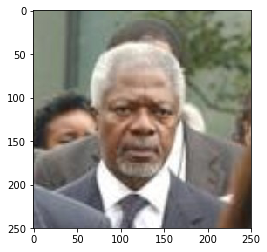

You mostly resemble a Borzoi for a dog breed..


Hey you awesome dog <=(^__^)=> 




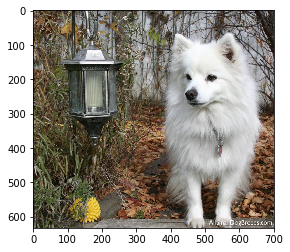

Your breed is American_eskimo_dog


Hello,.. human..^__^


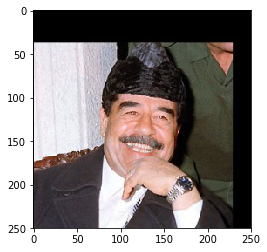

You mostly resemble a American_staffordshire_terrier for a dog breed..


Hello,.. human..^__^


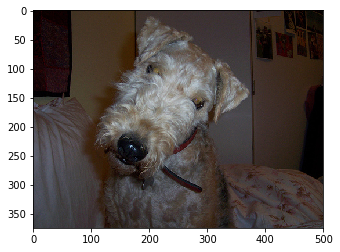

You mostly resemble a Lakeland_terrier for a dog breed..


Hello,.. human..^__^


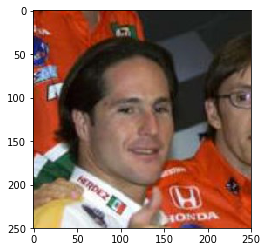

You mostly resemble a Portuguese_water_dog for a dog breed..


Hey you awesome dog <=(^__^)=> 




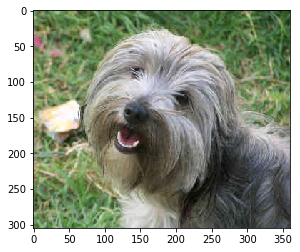

Your breed is Lhasa_apso




In [41]:
print('Dog Breed Classifier App')
for i in range(3):
    index = int(np.random.choice(len(human_files_short), 1, replace=True))
    breed_pred(human_files_short[index])
    breed_pred(dog_files_short[index])

THE OUTPUT IS WAY BETTER THAN EXPECTED.I RECEIVED AND 80% WHEN I THOUGHT IT WAS GOING TO BE 70%.. INCEPTION NET HAS THE APPROPRIATE WEIGHTS FOR THIS PROJECT GIVEN THE PARAMETERS . EVEN THOUGH THE ACCURACY IS VERY HIGH, THERE ARE  WAYS THIS EXPERIMENTED COULD BE IMPROVED AS IN:

    
-ADD MORE IMAGES
-ADD MORE HAAR CASCADES
-ADD MORE LAYERS